# <font style="color:purple"> Face Mask Detector - YOLO v3 - Linux</font>
-This notebook currently doesn't show predictions, I'm working on it!
                      ~G. Sayas

In [3]:
import random
import os
import subprocess
import sys
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt

from google.colab import drive
from datetime import datetime

%matplotlib inline



### <font color="pink">0.  Verification of the GPU </font>
Just seeing which GPU on the cloud with colab.

In [4]:
#Test to see if we are using the GPU
if 'GPU:0' in tf.test.gpu_device_name():
  print("Yeah, We are using the GPU!")
else:
  print("No GPU Allocated")

Yeah, We are using the GPU!


In [5]:
#Which type of GPU?
!nvidia-smi

Sun Apr 21 02:32:11 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P0              29W /  70W |    103MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### <font color="pink">1.  Load Google Drive</font>
We will load our google drive space to simplify the process

In [4]:
drive.mount('/content/drive')
!rm -rf /content/drive/My\ Drive/YOLO # clean install if exists

Mounted at /content/drive


### <font color="pink">2.  Change to the Drive space</font>
Now we will be inside our drive to allocate the files and also create a folder specifically to YOLO V3.

In [5]:
%cd /content/drive/My\ Drive
%mkdir YOLO

/content/drive/My Drive


### <font color="pink">3.  Download Alexey AB YOLO repository to our google drive *yolov3* folder</font>
We now will download the well maintained repository of a YOLO expert, because Joseph Redmon will not continue working on YOLO. :/

In [6]:
%cd /content/drive/My\ Drive/YOLO
!rm -rf darknet # clean folder if exists, sometimes when reconnecting gives error about permissions
!git clone https://github.com/AlexeyAB/darknet.git

/content/drive/My Drive/YOLO
Cloning into 'darknet'...
remote: Enumerating objects: 15833, done.
remote: Total 15833 (delta 0), reused 0 (delta 0), pack-reused 15833
Receiving objects: 100% (15833/15833), 14.39 MiB | 11.39 MiB/s, done.
Resolving deltas: 100% (10666/10666), done.
Updating files: 100% (2056/2056), done.


### <font color="pink">4.  Compile Darknet</font>
Modify some strings on the makefile to compile darknet.

In [7]:
%cd /content/drive/My\ Drive/YOLO/darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile

print("[INFO] - Building Darknet, this will take a few minutes. Get a coffee!")

!make &> build_log.txt

print("[INFO] - Build Finished!")


/content/drive/My Drive/YOLO/darknet
[INFO] - Building Darknet, this will take a few minutes. Get a coffee!
[INFO] - Build Finished!


### <font color="pink">5.  Download the *Mask / No Mask Dataset*</font>
Download the curated dataset of face mask and not facemask to our dataset folder, but first lets create a dataset folder.


In [8]:
%cd /content/drive/My\ Drive/YOLO
%mkdir dataset

/content/drive/My Drive/YOLO


In [9]:
%cd /content/drive/My\ Drive/YOLO/dataset
!wget https://www.dropbox.com/s/6gewe947ake1g95/kaggle_and_no-mask_dataset.zip
!unzip kaggle_and_no-mask_dataset.zip &> /dev/null
!rm -rf kaggle_and_no-mask_dataset.zip
!rm -rf .ipynb_checkpoints/

/content/drive/My Drive/YOLO/dataset
--2024-04-21 02:19:23--  https://www.dropbox.com/s/6gewe947ake1g95/kaggle_and_no-mask_dataset.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.71.18, 2620:100:6057:18::a27d:d12
Connecting to www.dropbox.com (www.dropbox.com)|162.125.71.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /scl/fi/lb13hhxkb8f8aubo6g8w1/kaggle_and_no-mask_dataset.zip?rlkey=5lf2oh8n948md7w1d5a25i26p [following]
--2024-04-21 02:19:24--  https://www.dropbox.com/scl/fi/lb13hhxkb8f8aubo6g8w1/kaggle_and_no-mask_dataset.zip?rlkey=5lf2oh8n948md7w1d5a25i26p
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucfdf432592a6234506c074a980b.dl.dropboxusercontent.com/cd/0/inline/CRaE9sQKEZB17EIZNxTMChtoc8oW_7YKJxckTltyqzEOlmMFqCEyPrDwjO5V-0b-o8jdxufJahtRs0TH4pXRIUzdiOCCejo4q5pwm5cVyCA-IRn9kOR3hswEvcbsOF4pKNopguJ7r2hFsY3-uxLb9a2v/file# [following]
--2024-04-21 02:19:25--  https:

### <font color="pink">6.  Prepare the Train and Test Files</font>
This code provided creates two files, one for the training images and other for the test images.

The dataset is divided in:
- 80% training set
- 20% test set

In [10]:
%cd /content/drive/My Drive/YOLO

image_dir = "./dataset"
f_val = open("DS_test.txt", 'w')
f_train = open("DS_train.txt", 'w')

path, dirs, files = next(os.walk(image_dir))
data_size = len(files)

ind = 0
data_test_size = int(0.2 * data_size)
test_array = random.sample(range(data_size), k=data_test_size)

for f in os.listdir(image_dir):
    if(f.split(".")[-1] == "jpg"):
        ind += 1

        if ind in test_array:
            f_val.write(image_dir+'/'+f+'\n')
        else:
            f_train.write(image_dir+'/'+f+'\n')

f_train.close()
f_val.close()

/content/drive/My Drive/YOLO


### <font color="pink">7.  Prepare and Upload the configuration files</font>

For train and use yolo we need to prepare the neccesary files, finally we will upload to our yolov3 folder:  **`yolov3-mask_nomask-setup.data`**,  **`yolov3-mask_nomask-train.cfg`** (based on the default file of darknet folder over the VOC dataset, yolov3-voc.cfg)... Width, Height, Channels, Momentum and Decay, Learning Rate, Steps, Scales, Burn In (warm-up), Data augmentation, Number of iterations, Change filters parameter & **`yolov3.names`** file.

### <font color="pink">8. Cloning the configuration Repository</font>
This repository is prepared with the desired configuration for yolov3 and yolov4.

In this case we will be using yolo v3.  The structure of the folder (for yolo v3 only for simplicity) is as follows:

```
/FacialMaskDetector
├── test
│   ├── test-image1.jpg
│   ├── test-image2.jpg
│   ├── test-image3.jpg
│   ├── test-image4.jpg
│   ├── test-video1.jpg
│   ├── test-video2.jpg
├── yolov3
│       ├── backup
│       │   ├── README.md
│       ├── config
│           ├── yolov3-mask_nomask-setup.data
│           ├── yolov3-mask_nomask-test.cfg
│           ├── yolov3-mask_nomask-train.cfg
│           ├── yolov3.names
│       ├── weights
│           ├── README.md
├── README.md
```

This will ease for us the way of training and inference.

In [11]:
%cd /content/drive/My Drive/YOLO
!git clone https://github.com/issaiass/FacialMaskDetector.git

/content/drive/My Drive/YOLO
Cloning into 'FacialMaskDetector'...
remote: Enumerating objects: 116, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 116 (delta 21), reused 37 (delta 11), pack-reused 67
Receiving objects: 100% (116/116), 68.51 MiB | 17.87 MiB/s, done.
Resolving deltas: 100% (46/46), done.
Updating files: 100% (25/25), done.


### <font color="pink">9. Cloning the Weights</font>
We will be doing fine-tuning, so we need to download the actual pre-trained weights.

In [12]:
%cd /content/drive/My\ Drive/YOLO/FacialMaskDetector/yolov3/weights

# Original File : https://pjreddie.com/media/files/darknet53.conv.74
!wget "https://www.dropbox.com/s/18dwbfth7prbf0h/darknet53.conv.74?dl=1" -O darknet53.conv.74

/content/drive/My Drive/YOLO/FacialMaskDetector/yolov3/weights
--2024-04-21 02:20:33--  https://www.dropbox.com/s/18dwbfth7prbf0h/darknet53.conv.74?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.71.18, 2620:100:6021:18::a27d:4112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.71.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /scl/fi/cte4fqetysju1dsccfjco/darknet53.conv.74?rlkey=bluydjd10mna3w539cuyrqf6n&dl=1 [following]
--2024-04-21 02:20:33--  https://www.dropbox.com/scl/fi/cte4fqetysju1dsccfjco/darknet53.conv.74?rlkey=bluydjd10mna3w539cuyrqf6n&dl=1
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc8e63f3fb8bc186f95c4aee2f35.dl.dropboxusercontent.com/cd/0/inline/CRZFmh0f6aHeTipQbBo2QDdulZPsAIIJ71QxMZJ0XZpNHNB9sq02lA70botlFZvhzeOOZG1j-WpsAt_lPsh9YYEnABv7SoGmeVYBqTriJ2fUEvy_4EurNKU2wfO4-jlEECHC1mWhWgwAE3AdYr15TNFM/file?dl=1# [following]
--2024-04-21 02:20:34--

### <font color="pink">10. Copy Labels Folder </font>

First we did a first step that is to copy the data folder of darknet to the root, because inside are the labels to graph the letters and numbers.  If this step is omited you will see a black box and no inference name.

In [6]:
%cd /content/drive/My\ Drive/YOLO
!mkdir data
!cp -R darknet/data/* ./data

/content/drive/My Drive/YOLO
mkdir: cannot create directory ‘data’: File exists


### <font color="pink">11. Review Hyperparameters</font>

If you want to change some hyperparameters this is a good way to do it.
Finally, always check your changes.

In [1]:
# this is for using as arguments of the terminal
yolo_setup        = 'FacialMaskDetector\/yolov3\/config\/yolov3-mask_nomask-setup.data'
yolo_train        = 'FacialMaskDetector\/yolov3\/config\/yolov3-mask_nomask-train.cfg'
yolo_test         = 'FacialMaskDetector\/yolov3\/config\/yolov3-mask_nomask-test.cfg'
yolo_weights      = 'FacialMaskDetector\/yolov3\/weights\/darknet53.conv.74'
yolo_best_weights = 'FacialMaskDetector\/yolov3\/backup\/yolov3-mask_nomask-train_best.weights'
yolo_test_path    = 'FacialMaskDetector\/test'

In [2]:
%cd /content/drive/My\ Drive/YOLO

#An example for changing specific lines in a file
#!sed -i 's/batch=32/batch=16/' $yolo_train
#!sed -i 's/subdivisions=16/subdivisions=8/' $yolo_train
#!sed -i 's/width=416/width=512/' $yolo_train
#!sed -i 's/height=416/height=512/' $yolo_train
#!sed -i 's/learning_rate=0.001/learning_rate=0.001/' $yolo_train
#!sed -i 's/burn_in=600/burn_in=3000/' $yolo_train
#!sed -i 's/max_batches=6000/max_batches=10000/' $yolo_train
#!sed -i 's/steps=4200,4800,5400/steps=7000,8000,9000/' $yolo_train
#!sed -i 's/scales=.1,.1,.1,.1/scales=.1,.1,.1/' $yolo_train

#Check if the configuration of hyperparameter is ok
!head -25 FacialMaskDetector/yolov3/config/yolov3-mask_nomask-train.cfg

/content/drive/My Drive/YOLO
# Based on cfg/yolov3-voc.cfg

[net]
# Testing
# batch=1
# subdivisions=1
# Training
batch=16
subdivisions=8
width=512
height=512
channels=3
momentum=0.9
decay=0.0005
angle=0
saturation = 1.5
exposure = 1.5
hue=.1

learning_rate=0.001
burn_in=3000
max_batches=10000
policy=steps
steps=7000,8000,9000
scales=.1,.1,.1


### <font color="pink">12. Let's do some Training! </font>

We need to pass the training files for the darknet framework to start the process.

Remember!, we need to specify the complete paths of these files that we talked before:
1. setup file,
1. config file,
1. convolutional weights file

There are a few flags like **`dont_show`** which wont display the graphs and **`map`** - for the mAP calculation over the DS_test.txt file (20% of our data).

In [7]:
%cd /content/drive/My\ Drive/YOLO
#!chmod 777 /content/drive/My\ Drive/YOLO/darknet/darknet
!./darknet/darknet detector train  $yolo_setup $yolo_train $yolo_weights -dont_show -map 2> train_log.txt

Se han truncado las últimas 5000 líneas del flujo de salida.
 (next mAP calculation at 3000 iterations) 1891/10000: loss=2.7 hours left=5.4
 1891: 2.741735, 2.146902 avg loss, 0.000158 rate, 1.559732 seconds, 30256 images, 5.438524 hours left
Loaded: 0.000039 seconds

 (next mAP calculation at 3000 iterations) 1892/10000: loss=1.6 hours left=5.4
 1892: 1.634810, 2.095693 avg loss, 0.000158 rate, 1.422162 seconds, 30272 images, 5.419273 hours left
Loaded: 0.000038 seconds

 (next mAP calculation at 3000 iterations) 1893/10000: loss=2.2 hours left=5.4
 1893: 2.217791, 2.107903 avg loss, 0.000159 rate, 1.417913 seconds, 30288 images, 5.397112 hours left
Loaded: 0.000051 seconds

 (next mAP calculation at 3000 iterations) 1894/10000: loss=2.6 hours left=5.4
 1894: 2.638911, 2.161003 avg loss, 0.000159 rate, 1.497239 seconds, 30304 images, 5.375073 hours left
Loaded: 0.000038 seconds

 (next mAP calculation at 3000 iterations) 1895/10000: loss=3.0 hours left=5.4
 1895: 3.036507, 2.2485

Our results:

- Last accuracy mAP@0.5 = 87.71 %, best = 88.44 %
 10000: 0.678672, 0.730213 avg loss, 0.000001 rate, 3.044799 seconds, 160000 images, 0.056984 hours left

- detections_count = 3096, unique_truth_count = 1517  
- class_id = 0, name = Mask, ap = 92.32%   	 (TP = 462, FP = 42)
- class_id = 1, name = No-Mask, ap = 82.30%   	 (TP = 747, FP = 93)

And the training time was about 8 to 10 hours.



_____

with the first 1000 we only got to 28 of mAP :c

### <font color="pink">13. Displaying code</font>

This code will display in the same canvas both images, the original one and the yolo predictions marked on it.

In [25]:
def display_output(imagePath):
    src = cv2.imread(imagePath,1)
    output = cv2.imread("predictions.jpg")

    plt.figure(figsize=[20,8])
    plt.subplot(121)
    plt.imshow(src[:,:,::-1])
    plt.title("Original Image")
    plt.subplot(122)
    plt.imshow(output[:,:,::-1])
    plt.title("Predictions")

    file_name = imagePath.split('\\')
    file_name_parts = file_name[2].split('.')
    name_only = file_name_parts[0]
    now = datetime.now() # current date and time
    build = now.strftime("%m-%d-%Y_%H_%M_%S")
    file_save_path = os.path.join(file_name[0], 'result', 'yolov4')
    save_name = os.path.join(file_save_path, name_only + '-yolov4--' + build +'.png')
    plt.savefig(save_name)

    plt.show()

### <font color="pink">14. Making Inferences </font>

This code will display in the same canvas both images, the original one and the yolo predictions marked on it.

Finally are the inferences of images and pre-recorded video.

The pre-recorded video could be downloaded over the root folder, in this case, our YOLO folder (created on Google Drive).

Here are the files paths:

In [26]:
%cd /content/drive/My\ Drive/YOLO
!mkdir data
!Xcopy /E /I darknet\data\* data
yolo_test_path = os.path.join('FacialMaskDetector', 'test')
test_files = [os.path.join(yolo_test_path, v) for v in os.listdir(yolo_test_path)]

/content/drive/My Drive/YOLO
mkdir: cannot create directory ‘data’: File exists
/bin/bash: line 1: Xcopy: command not found


In [37]:
!pip install darknet

#### <font color="pink">14.1 Scenario 1</font>

Testing only with one man and with facemask....aaand it doesn't work :c

/content/drive/My Drive/YOLO
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
Create CUDA-stream - 0 
 Create cudnn-handle 0 


TypeError: 'NoneType' object is not subscriptable

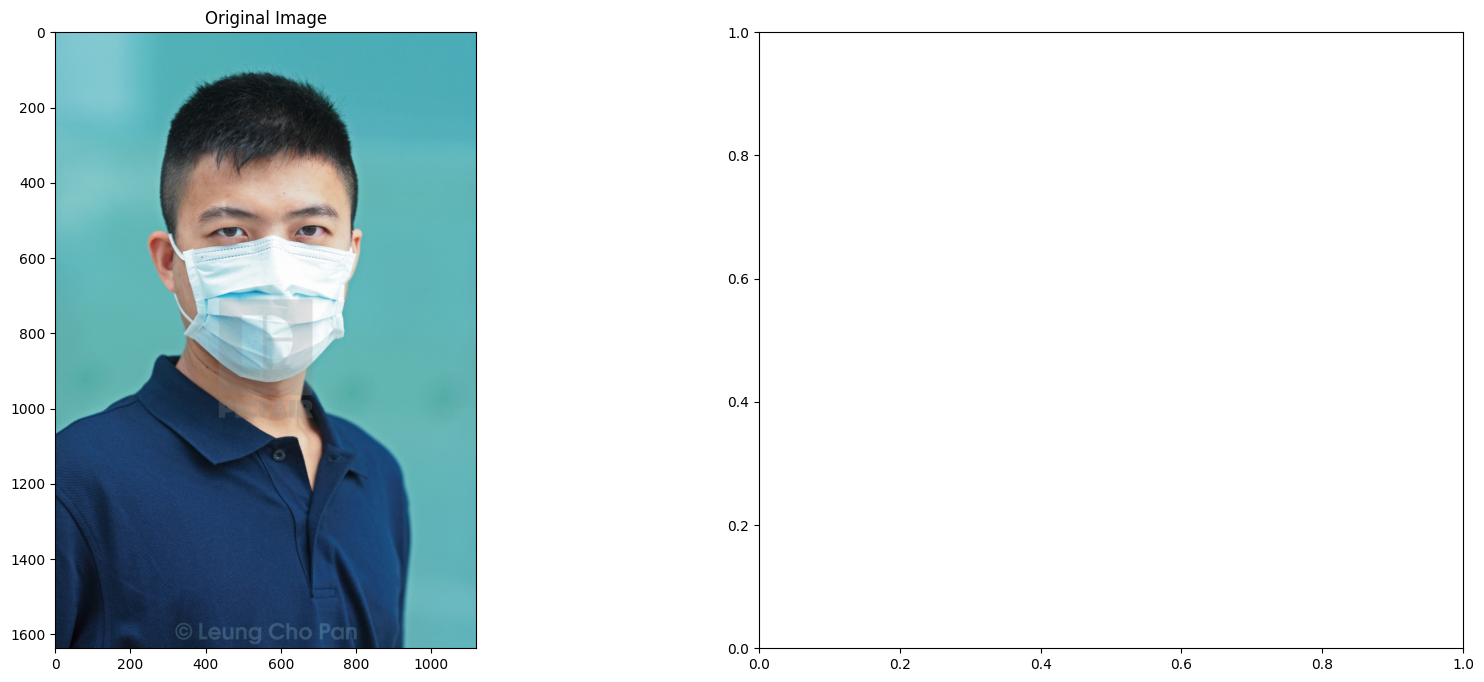

In [38]:
# Uncomment the line belowif you prebuilt darknet and want to change the permissions of the file
#!chmod 777 /content/drive/My\ Drive/YOLO/darknet/darknet
%cd /content/drive/My\ Drive/YOLO
!./darknet/darknet detector test $yolo_setup $yolo_test $yolo_best_weights FacialMaskDetector/test/test-image1.jpg -thresh .6 2> /dev/null


display_output(test_files[0])

#### <font color="pink">14.2 Scenario 2</font>

Testing with different angles of people wearing mask and other not wearing.

In [ ]:
!./darknet/darknet detector test $yolo_setup $yolo_test $yolo_best_weights FacialMaskDetector/test/test-image2.jpg -thresh .6 2> /dev/null
display_output(test_files[1])

#### <font color="pink">14.3 Scenario 3</font>

Testing with a crowd with and without facemask and different scales and variations

In [ ]:
!./darknet/darknet detector test $yolo_setup $yolo_test $yolo_best_weights FacialMaskDetector/test/test-image3.jpg -thresh .6 2> /dev/null
display_output(test_files[2])

#### <font color="pink">14.4 Scenario 4</font>

Testing with several people walking trough the plaza.

In [ ]:
!./darknet/darknet detector test $yolo_setup $yolo_test $yolo_best_weights FacialMaskDetector/test/test-image4.jpg -thresh .5 2> /dev/null
display_output(test_files[3])

#### <font color="pink">14.5 Scenario 5</font>

Testing over a video of people wearing or not wearing mask, good lighting conditions.

In [ ]:
!./darknet/darknet detector demo $yolo_setup $yolo_test $yolo_best_weights FacialMaskDetector/test/test-video1.mp4 -thresh .6 2 -out_filename out-vid1.avi -dont_show

#### <font color="blue">14.6 Scenario 6</font>

A video of the crowd.  Variable ligth conditions.

In [ ]:
!./darknet/darknet detector demo $yolo_setup $yolo_test $yolo_best_weights FacialMaskDetector/test/test-video2.mp4 -thresh .6 2 -out_filename out-vid2.avi -dont_show

Finally move the video files to the output folder

In [11]:
!cd /content/drive/My\ Drive/YOLO
!mv out-vid1.avi FacialMaskDetector/result/yolov3
!mv out-vid2.avi FacialMaskDetector/result/yolov3

mv: cannot stat 'out-vid1.avi': No such file or directory
mv: cannot stat 'out-vid2.avi': No such file or directory
